Phishing emails: 12562
Top Senders: 15
Top Domains: 15
Graph nodes: 25
Graph edges: 18


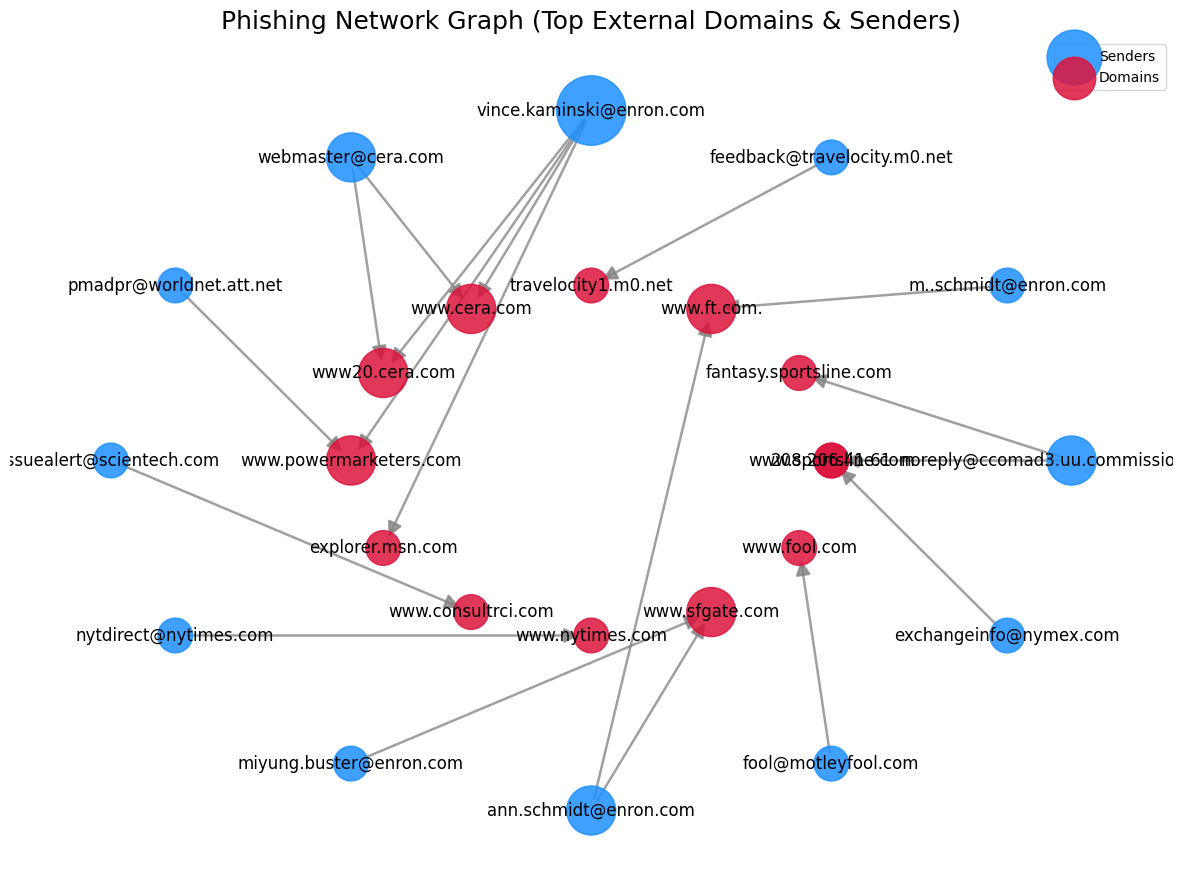

In [73]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from urllib.parse import urlparse

# =========================
# 1) Read data
# =========================
df = pd.read_csv("graph_data.csv")

# Use phishing only
df = df[df["possible_phishing"] == 1]

print("Phishing emails:", len(df))

# =========================
# 2) Extract domains
# =========================
def extract_domains(urls):
    domains = []
    for url in str(urls).split():
        try:
            domain = urlparse(url).netloc.lower()
            if domain:
                domains.append(domain)
        except:
            pass
    return domains

df["domains"] = df["url"].apply(extract_domains)

# =========================
# 3) Remove internal domains
# =========================
INTERNAL_DOMAINS = ["enron.com"]

def is_external(domain):
    return not any(internal in domain for internal in INTERNAL_DOMAINS)

df["domains"] = df["domains"].apply(
    lambda ds: [d for d in ds if is_external(d)]
)

# =========================
# 4) Frequency analysis (increase node count)
# =========================
TOP_SENDERS = 15
TOP_DOMAINS = 15

top_senders = (
    df["from"]
    .value_counts()
    .head(TOP_SENDERS)
    .index
    .tolist()
)

top_domains = (
    df.explode("domains")["domains"]
    .value_counts()
    .head(TOP_DOMAINS)
    .index
    .tolist()
)

print("Top Senders:", len(top_senders))
print("Top Domains:", len(top_domains))

# =========================
# 5) Build graph
# =========================
G = nx.DiGraph()


for _, row in df.iterrows():
    sender = row["from"]

    if sender not in top_senders:
        continue

    for domain in row["domains"]:
        if domain in top_domains:
            G.add_edge(sender, domain)

print("Graph nodes:", G.number_of_nodes())
print("Graph edges:", G.number_of_edges())

# =========================
# 6) Degree centrality
# =========================
centrality = nx.degree_centrality(G)

# =========================
# 7) Visualization
# =========================
plt.figure(figsize=(15, 11))




# Separate node types
sender_nodes = [n for n in G.nodes() if "@" in n]
domain_nodes = [n for n in G.nodes() if "@" not in n]

pos = {}
angle_step = 2 * 3.1415 / len(sender_nodes)
radius = 4

for i, node in enumerate(domain_nodes):
    pos[node] = (radius * np.cos(i * angle_step), radius * np.sin(i * angle_step))

for i, node in enumerate(sender_nodes):
    pos[node] = (2*radius * np.cos(i * angle_step), 2*radius * np.sin(i * angle_step))

# Node sizes
node_sizes = [15000 * centrality[n] for n in G.nodes()]

# Draw Senders
nx.draw_networkx_nodes(
    G, pos,
    nodelist=sender_nodes,
    node_color="dodgerblue",
    node_size=[15000 * centrality[n] for n in sender_nodes],
    label="Senders",
    alpha=0.85
)

# Draw Domains
nx.draw_networkx_nodes(
    G, pos,
    nodelist=domain_nodes,
    node_color="crimson",
    node_size=[15000 * centrality[n] for n in domain_nodes],
    label="Domains",
    alpha=0.85
)

# Edges
nx.draw_networkx_edges(
    G,
    pos,
    edge_color="gray",
    arrows=True,
    arrowstyle="-|>",
    arrowsize=22,
    width=1.8,
    alpha=0.75
)


# Labels only for most important nodes
top_nodes = sorted(
    centrality, key=centrality.get, reverse=True
)[:25]

labels = {n: n for n in top_nodes}

nx.draw_networkx_labels(
    G, pos,
    labels,
    font_size=12
)

plt.legend(scatterpoints=1)
plt.title("Phishing Network Graph (Top External Domains & Senders)", fontsize=18)
plt.axis("off")
plt.show()
